## Data processing construction example using CrossAI 

#### Disable Warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')

#### Import Configuration Module

In [2]:
import yaml

#### Load Configuation

In [3]:
with open("../config.yml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

#### Load Data
Store into a dataframe which will contain all data and the respective class label (which is stored in the last column of the dataframe)

In [4]:
data_dir_path = config['PATH']['RAW']['MINI_SPEECH_COMMANDS'] # store to dataframe
SAMPLE_RATE = 16000

In [5]:
from crossai.loader import audio_loader

# All signals are resampled at `SAMPLE_RATE` and normalised (0, 1)
df = audio_loader(path=data_dir_path, sr=SAMPLE_RATE)

Loaded data into the dataframe: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]                                                   


Create a crossai audio object which will be used for the exploitation of the data processing pipeline.

cai_audio.data holds the data in a dataframe: each row/signal is np.float32  
and cai_audio.lalbels holds the data labels in a dataframe

In [6]:
from crossai.pipelines.audio import Audio

cai_audio = Audio(df)
cai_audio.data.head()

0    [0.506821, 0.50676304, 0.50670505, 0.5071688, ...
1    [0.53376144, 0.5336966, 0.5336966, 0.5336966, ...
2    [0.6036141, 0.6044156, 0.6044885, 0.6037598, 0...
3    [0.4621682, 0.45547011, 0.4510047, 0.44058546,...
4    [0.5535465, 0.5521018, 0.55163574, 0.5524979, ...
Name: data, dtype: object

In [7]:
cai_audio.labels.head(), cai_audio.labels.value_counts()

(0    left
 1    left
 2    left
 3    left
 4    left
 Name: label, dtype: object,
 label
 left     1000
 go       1000
 right    1000
 up       1000
 stop     1000
 yes      1000
 down     1000
 no       1000
 Name: count, dtype: int64)

#### Pipeline Construction
- Pad the audio data
- Apply band-pass filtering
- Extract Spectrogram
- Convert to df

Create custom functions for data processing , either 1D or 2D and generate their respective pipeline transformers.

In [9]:
from crossai.pipelines.timeseries import Transformer
from crossai.processing.filter import butterworth_filter
from crossai.processing.audio import melspectrogram
from crossai.pipelines.timeseries import ToPandas
from crossai.pipelines.timeseries import PadOrTrim

POT = PadOrTrim(fill_value=0, pad_type="mean")
Butterworth = Transformer(
    butterworth_filter, 
    f_type='bp',
    sr=SAMPLE_RATE, 
    cutoff_low=300, 
    cutoff_high=3400, 
    order=6
)
Spectrogram = Transformer(
    melspectrogram,
    sr=SAMPLE_RATE, 
    n_fft=1024, 
    hop_length=512,
    n_mels=128, 
    fmin=0, 
    fmax=4000, 
    power=2.0
)
TP = ToPandas()

Fit and transform crossai audio data using the transformers.

ToPandas is used to transform the data back to pandas-series form.

In [10]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('pad_or_trim', POT),
    ('filter', Butterworth),
    ('spectrogram', Spectrogram),
    ('TP', TP)
])

pipe.fit_transform(cai_audio)

In [11]:
cai_audio.data

0       [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
1       [[-78.44596119206062, -80.0, -80.0, -80.0, -80...
2       [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
3       [[-51.65072104701758, -80.0, -80.0, -80.0, -80...
4       [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
                              ...                        
7995    [[-77.70423084679652, -80.0, -80.0, -80.0, -80...
7996    [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
7997    [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
7998    [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
7999    [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
Length: 8000, dtype: object

In [12]:
cai_audio.labels

0       left
1       left
2       left
3       left
4       left
        ... 
7995      no
7996      no
7997      no
7998      no
7999      no
Name: label, Length: 8000, dtype: object

Now the crossai audio data is transformed through the processing pipeline.

<h4> Spectrogram visualization example<h4>

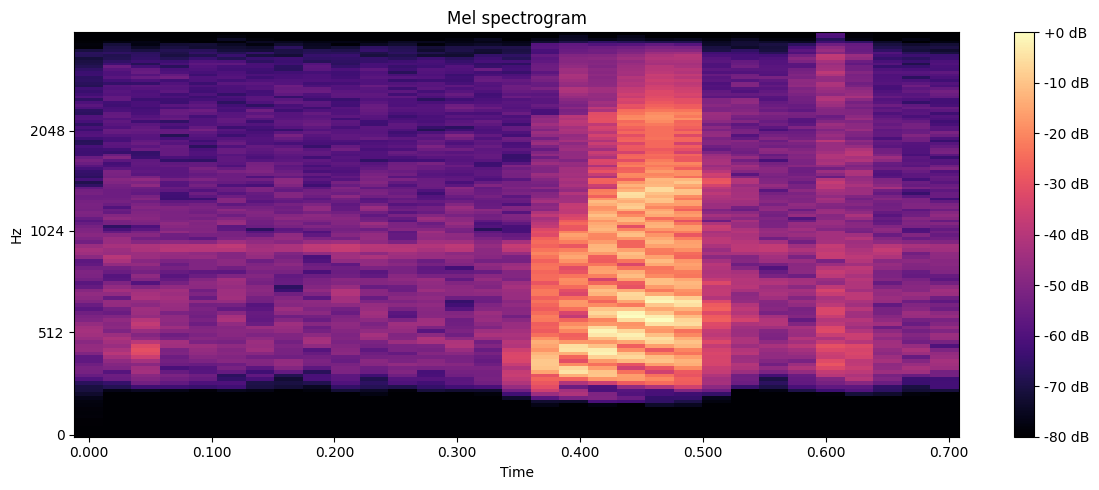

In [13]:
import matplotlib.pyplot as plt
import librosa.display

spec = cai_audio.data[210]

plt.figure(figsize=(12, 5))
librosa.display.specshow(spec, y_axis='mel', fmax=4000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()